In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
from scipy import stats
from IPython.core.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings("ignore")

## [URL](https://github.com/pymc-devs/resources/blob/master/BCM/ParameterEstimation/Latent-mixtureModels.ipynb?fbclid=IwAR3k1Mt2R0nAcE7FH1XIRApV-kj380dSbuyfXvYbJzBt5-QiK_4c0de4njg)

## 6.1 Exam scores

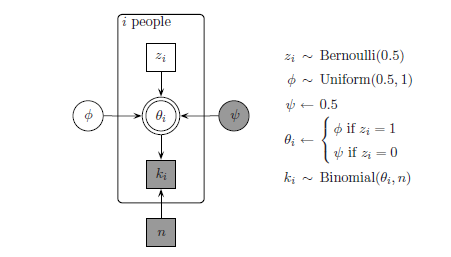

In [4]:
display(Image('./5_6_img/6_1.PNG', unconfined=True))

* 15명 40(T/F질문)
* 5명은 찍은 그룹 10명은 아는 그룹
* 통계적 추론을 하는 한가지 방법은 두 그룹이 다른 그룹이란 것을 가정한다
* 추측하는 구릅은 답변 성공 확률 0.5$\psi$ , 아는 그룹은 0.5보다 높을 것이다$\phi$
*  $z_i$ 두 그룹중에 하나로 분류하기 위한 변수
* $\theta$ ,   $z_i$에 따라서 $\phi , \psi$주게 하는 변수 
* $k_i$ 그 정해진 그룹에 대한 40가지 문제에 대한 binomial

* 이렇게 잠재되서 혼합된 모형을 `latent-mixture model` 이라고 함.
* 데이터가 다른 두 과정에서 결합되거나 합쳐되서 관측되지 않은 것에 중요한 성질을 만들어 낸다고 가정

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [phi]
>BinaryGibbsMetropolis: [zi]
Sampling 4 chains: 100%|██████████| 12400/12400 [00:08<00:00, 1545.23draws/s]
The acceptance probability does not match the target. It is 0.9290493728020689, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292454985157538, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9380704611034657, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9232408705859214, but should be close to 0.8. Try to increase the number of tuning steps.


Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


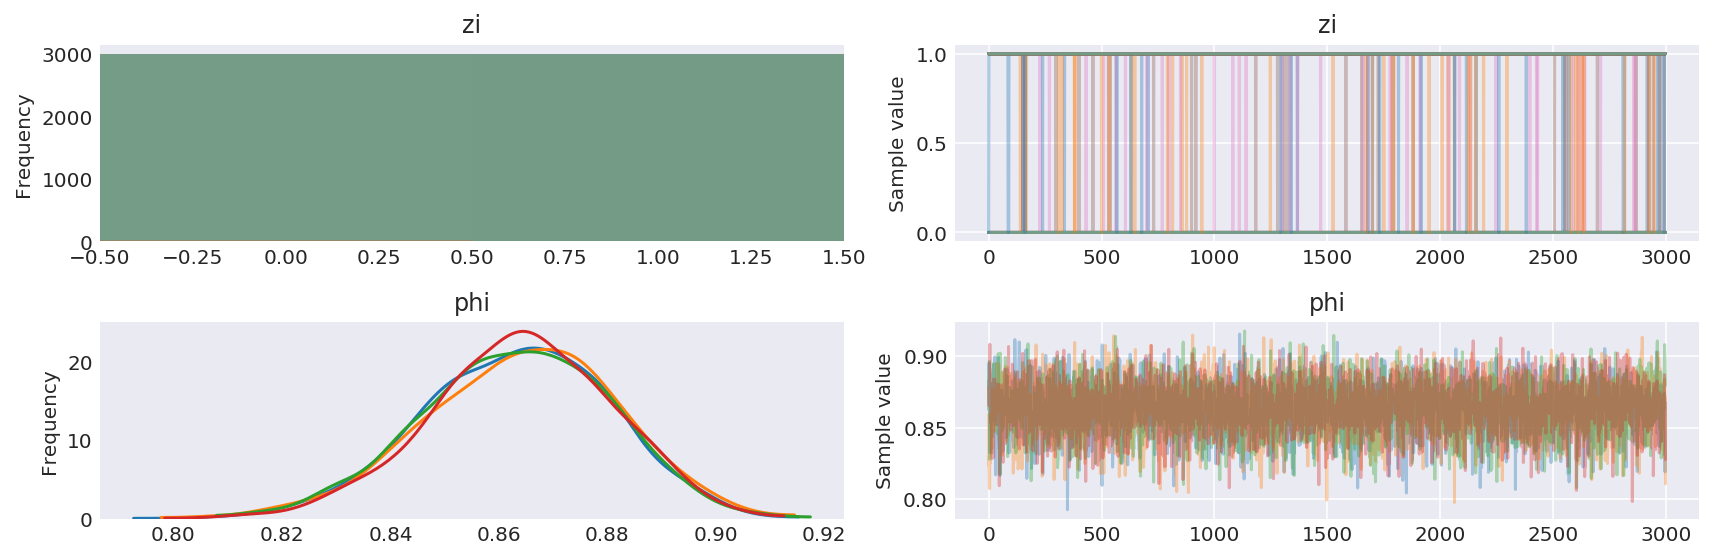

In [5]:
# pymc3
k = np.array([21,17,21,18,22,31,31,34,34,35,35,36,39,36,35])
p = len(k) #number of people
n = 40 # number of questions

with pm.Model() as model1:
    # group prior 
    # 사전에 0.5 확률 
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    # accuracy prior
    # 정답을 아는 그룹은 확률이 0.5 이상일 것이다.
    phi = pm.Uniform('phi', upper=1, lower=.5)
    # 찍는 그룹은 확률이 0.5
    psi = .5
    # 베르누이에서 나온 값이 1이면 phi 와 곱해지고 
    # 베르누이에서 나온 값이 0이면 psi(0.5)와 곱해진다. 결국 둘장 하나만 만족
    theta = pm.Deterministic('theta', phi*tt.eq(zi, 1) + psi*tt.eq(zi, 0))
    # observed
    # 위에서 나온 theta 에서 n개의 질문 중 몇개나 맞추는 지
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    trace1=pm.sample(3000, tune=100)

pm.traceplot(trace1, ['zi', 'phi']);

ztrace = trace1['zi']
print('Grouping', ztrace[-1, :])

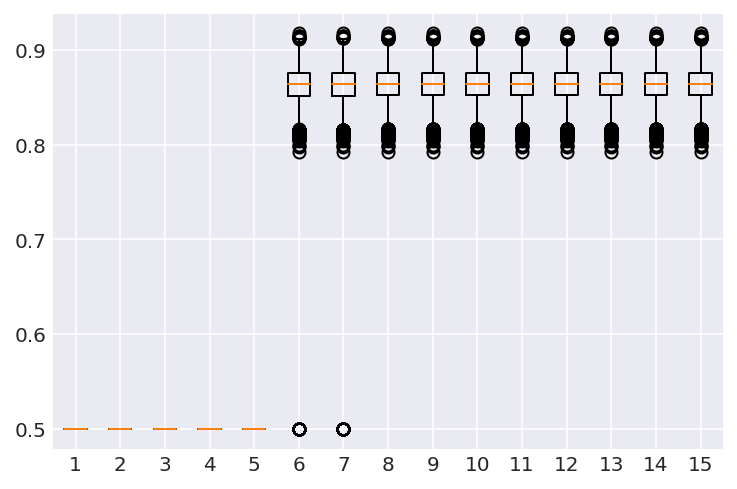

In [8]:
plt.figure()
thetapost = trace1['theta']
plt.boxplot(thetapost);

## 6.2 Exam scores with individual differences

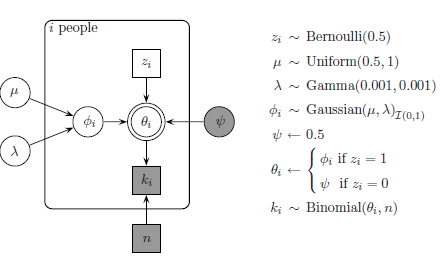

In [6]:
display(Image('./5_6_img/6_2.PNG', unconfined=True))

* 6.1 에서는 질문에 대한 성공의 확률을 모두 같다고 가정했다는 단점이 있다.
* 편한 방법은 개인의 차를 gaussian 분포를 따른다고 하는 것이다. 
    * 여기에 한가지 문제가 있는 것은 성공의 확률은 0 ~ 1 사이라는 것이다.
    * 그래서 유효한 범위에서만 된다고 가정한다.

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi, lambda_, mu]
>BinaryGibbsMetropolis: [zi]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:23<00:00, 346.96draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Grouping [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


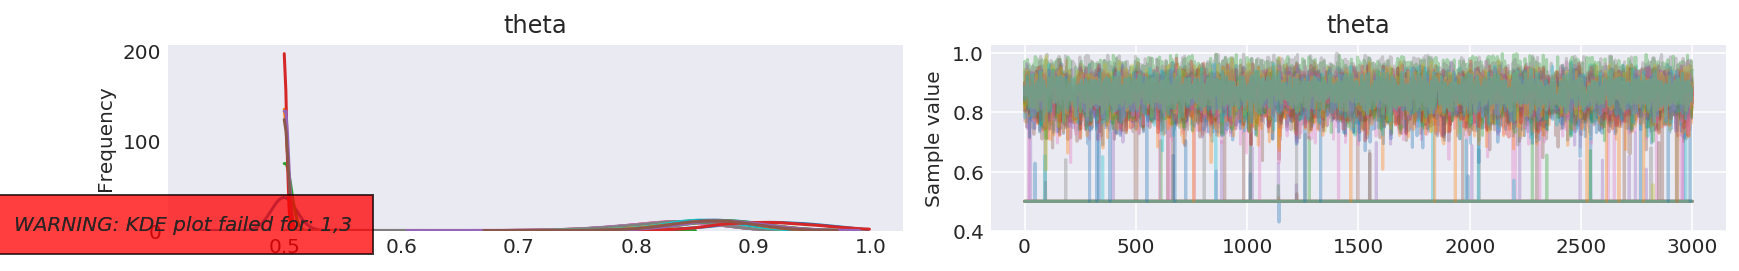

In [7]:
# pymc3 - need some tuning to get the same result as in JAGS
k = np.array([21,17,21,18,22,31,31,34,34,35,35,36,39,36,35])
p = len(k) #number of people
n = 40 # number of questions

with pm.Model() as model2:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    # accuracy prior
    psi = .5
    ## phi는 사람들마다 다 다를 것이다.
    ## 그래서 mu는 알 확률이므로 >0.5
    mu = pm.Uniform('mu', upper=1, lower=.5)
    ## 분산이 거의 영향을 주지않기 위해 point mass 방식으로 아주 작게
    lambda_ = pm.Gamma('lambda_', alpha=.001, beta=.001)
    ## Bound 로 0 ~ 1 로 제한을 하는 것 같다.
    phi = pm.Bound(pm.Normal, 0, 1)('phi', mu=mu, tau=lambda_, shape=p)
    ##  switch 함수의 느낌은 조건이 맞으면 phi  아니면 psi
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 1), phi, psi))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    trace2=pm.sample(3000, cores=2, tune=1000)

pm.traceplot(trace2, ['theta']);

ztrace = trace2['zi']
print('Grouping', ztrace[-1, :])

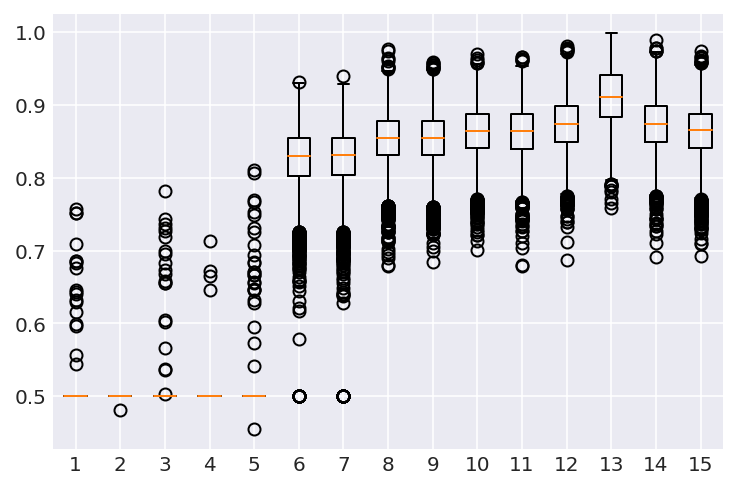

In [4]:
plt.figure()
thetapost = trace2['theta']
plt.boxplot(thetapost);

## 6.3 Twenty questions

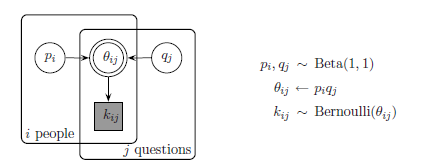

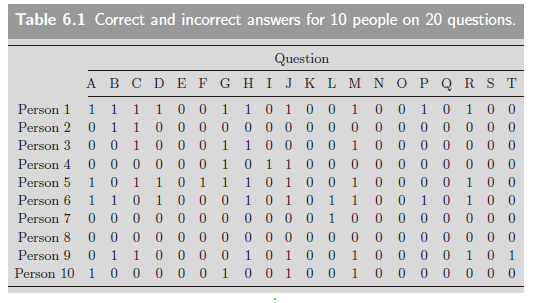

In [11]:
display(Image('./5_6_img/6_3.PNG', unconfined=True))
display(Image('./5_6_img/6_3_1.PNG', unconfined=True))

* 10명의 사람이 각가의 질문에 대해서 맞는지 틀린 지 보여주는 표
* 2가지 추론을 원함.
    * 1. 각가의 사람이 수업에 잘 참여했는지?
    * 2. 각가의 질문이 얼마나 어려웠는지?
    
* 사람의 집중도와 문제의 난이도가 결합한 맞출 전체적인 확률값을 추론하는 방법
* 가정
    * 각각의 사람들은 수업을 같은 비율로 듣는다.
    * 각각의 질문은 만약 수업을 잘 들었다면 올바르게 답할 수 확률은 같다고 하는 것

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [qi, pi]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:10<00:00, 1456.83draws/s]


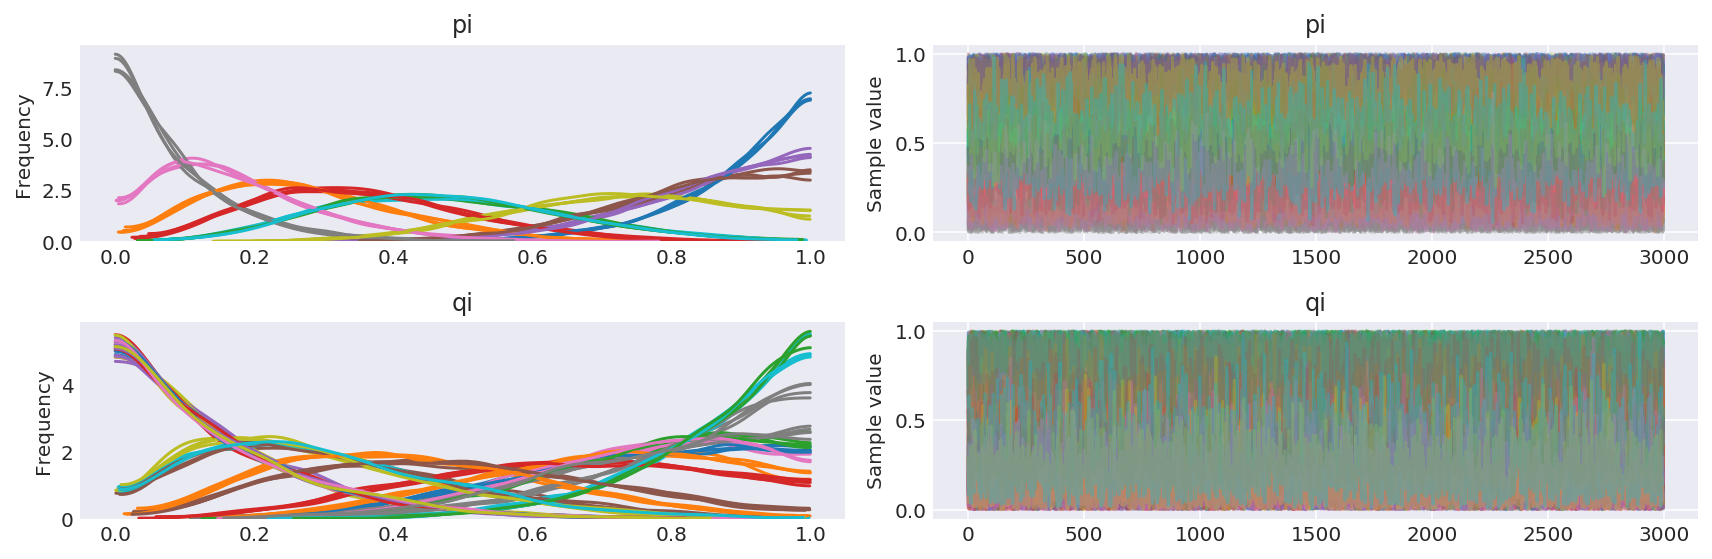

In [12]:
import warnings
warnings.filterwarnings("ignore")

dset = 1


if dset==1:
    k = np.array([
        1,1,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
    ]).reshape(10,-1)
elif dset==2:
    ##  mask 씌우기 -999 면 TRUE
    k = np.ma.masked_values([
        1,1,1,1,0,0,1,1,0,1,0,0,-999,0,0,1,0,1,0,0,
        0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,
        0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,
        1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,
        1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,
        0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,
        0,0,0,0,-999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,
        1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,-999,0,0
    ], value=-999).reshape(10,-1)
    
# print(k)
Np, Nq = k.shape

with pm.Model() as model3:
    # prior uniform(0,1) = Beta(1,1)
    pi = pm.Beta('pi', alpha=1, beta=1, shape=Np)
    qi = pm.Beta('qi', alpha=1, beta=1, shape=Nq)
    # accuracy prior
    theta = pm.Deterministic('theta', tt.outer(pi, qi))
    # observed
    ## 어떤 사람이 맞춘거와 안맞춘 자료이므로  1, 0
    kij = pm.Bernoulli('kij', p=theta, observed=k)
    
    trace3=pm.sample(3000, tune=1000)

pm.traceplot(trace3, ['pi', 'qi']);

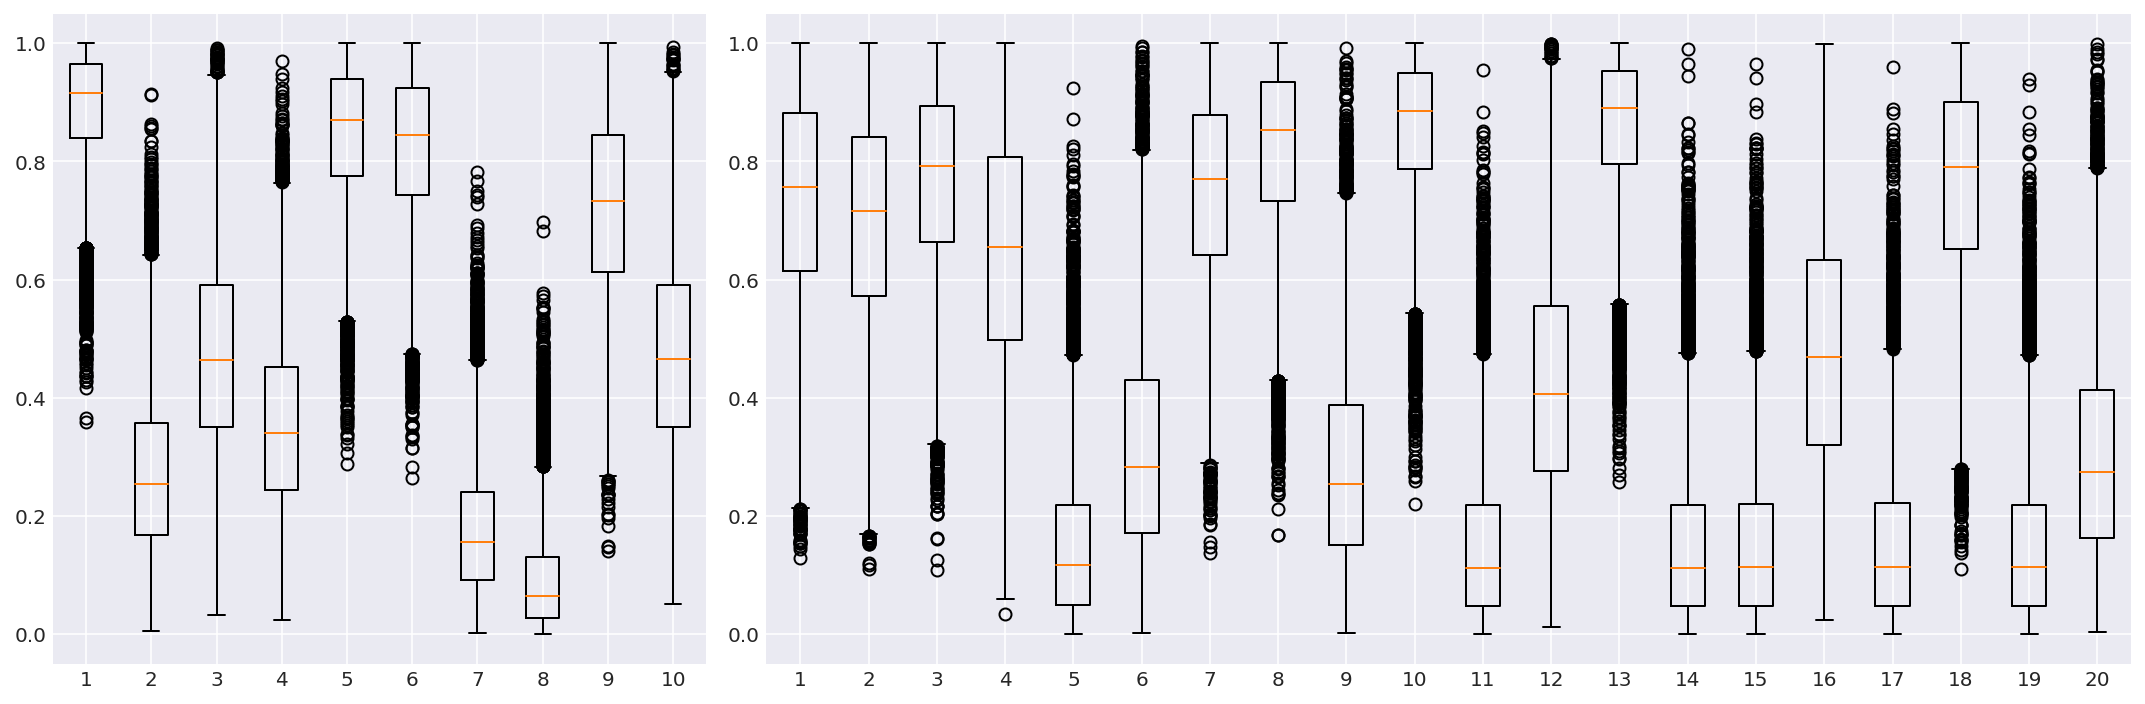

In [13]:
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax0 = plt.subplot(gs[0])
## 10명 사람이 맞출 확률 
pipost = trace3['pi']
ax0.boxplot(pipost)
## 20문제 맞출 확률
ax1 = plt.subplot(gs[1:])
qipost = trace3['qi']
ax1.boxplot(qipost)

plt.tight_layout();

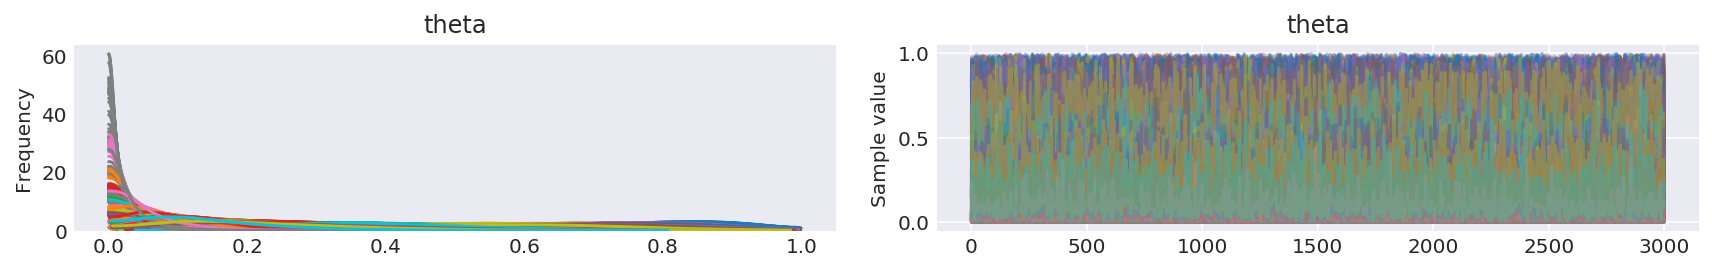

In [14]:
pm.traceplot(trace3, ['theta']);

## 6.4 The two-country quiz

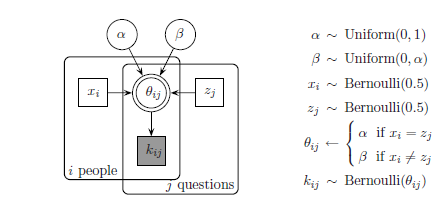

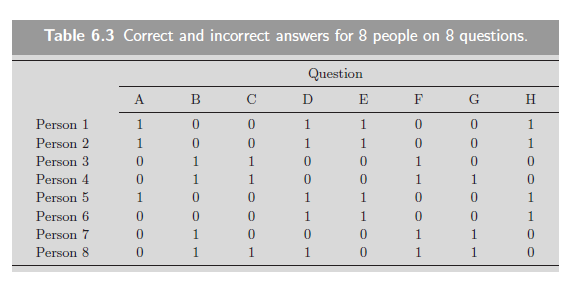

In [16]:
display(Image('./5_6_img/6_4.PNG', unconfined=True))
display(Image('./5_6_img/6_4_1.PNG', unconfined=True))

* 역사퀴즈를 8명의 사람이 8문제를 봤다고 하자. (올바르게 답했는지 , 아니었는지)
* 몇몇은 Thai , 몇몇은 Moldvan 
* 몇몇퀴즈는 Thai 역사관한 퀴즤여서 Moldovan 보다 Thai 사람이 더 잘 출 것 같다고 한다.
* 대신 지금 누가 어느 나라 사람인지는 모른다.
* 질문의 항목도 잘 모른다.
* $\beta$는 다른 나라 질문에 대해서 제대로 답 할 확률 (낮은 확률일것이라 가정한다.)
* $\alpha$ 자기 나라 문제 잘 답할 확률
* 

In [17]:
dset = 1
if dset==1:
    k = np.array([
      1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0
    ]).reshape(8,-1)
elif dset==2:
    k = np.ma.masked_values([1,0,0,1,1,0,0,1,
      1,0,0,1,1,0,0,1,
      0,1,1,0,0,1,0,0,
      0,1,1,0,0,1,1,0,
      1,0,0,1,1,0,0,1,
      0,0,0,1,1,0,0,1,
      0,1,0,0,0,1,1,0,
      0,1,1,1,0,1,1,0,
      1,0,0,1,-999,-999,-999,-999,
      0,-999,-999,-999,-999,-999,-999,-999,
      -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(11,-1)
elif dset==3:
    k = np.ma.masked_values([
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        1,0,0,1,1,0,0,1,
        0,1,1,0,0,1,0,0,
        0,1,1,0,0,1,1,0,
        1,0,0,1,1,0,0,1,
        0,0,0,1,1,0,0,1,
        0,1,0,0,0,1,1,0,
        0,1,1,1,0,1,1,0,
        1,0,0,1,-999,-999,-999,-999,
        0,-999,-999,-999,-999,-999,-999,-999,
        -999,-999,-999,-999,-999,-999,-999,-999
    ], value=-999).reshape(21,-1)

Nx, Nz = k.shape

with pm.Model() as model4:
    # prior
    #  자기 나라에 대한 역사문제를 잘 맞출 것이다.
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    # 다른 나라에 대한 역사를 잘 맞출 것이다.
    ## 그 때 자기 나라보다는 더 못맞출 확률 것이라고 가정해서 upper를 제한을 준다.
    beta = pm.Uniform('beta', lower=0, upper=alpha)
    ## 사람 마다 맞췄는지 아닌지
    xi = pm.Bernoulli('xi', p=.5, shape=(Nx, 1))
    ## 문제를 맞췄는지 아닌지
    zj = pm.Bernoulli('zj', p=.5, shape=(1, Nz))
    
    # 만약 맞추게 되면 이사람은 자기 나라 퀴즈에 대해서 맞춘 것일 것이고
    # 아니라면 다른 나라에 관한 역사 퀴즈를 맞춘 것일꺼다.
    theta = pm.Deterministic('theta', tt.switch(tt.eq(xi, zj), alpha, beta))
        
    # observed
    ## 
    kij = pm.Bernoulli('kij', p=theta, observed=k)
    ## ?? Slice 무슨 역할을 하는 것인지 모르겠다
    ## 찾아보니 parameter 마다  다르게 sampler 한다는 것 같다.(불확실)
    step = pm.Slice([alpha, beta])
    trace4 = pm.sample(3000, cores=2, tune=1000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>BinaryGibbsMetropolis: [xi, zj]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:14<00:00, 554.25draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


xi [1 1 0 0 1 1 0 0]
zj [1 0 0 1 1 0 0 1]


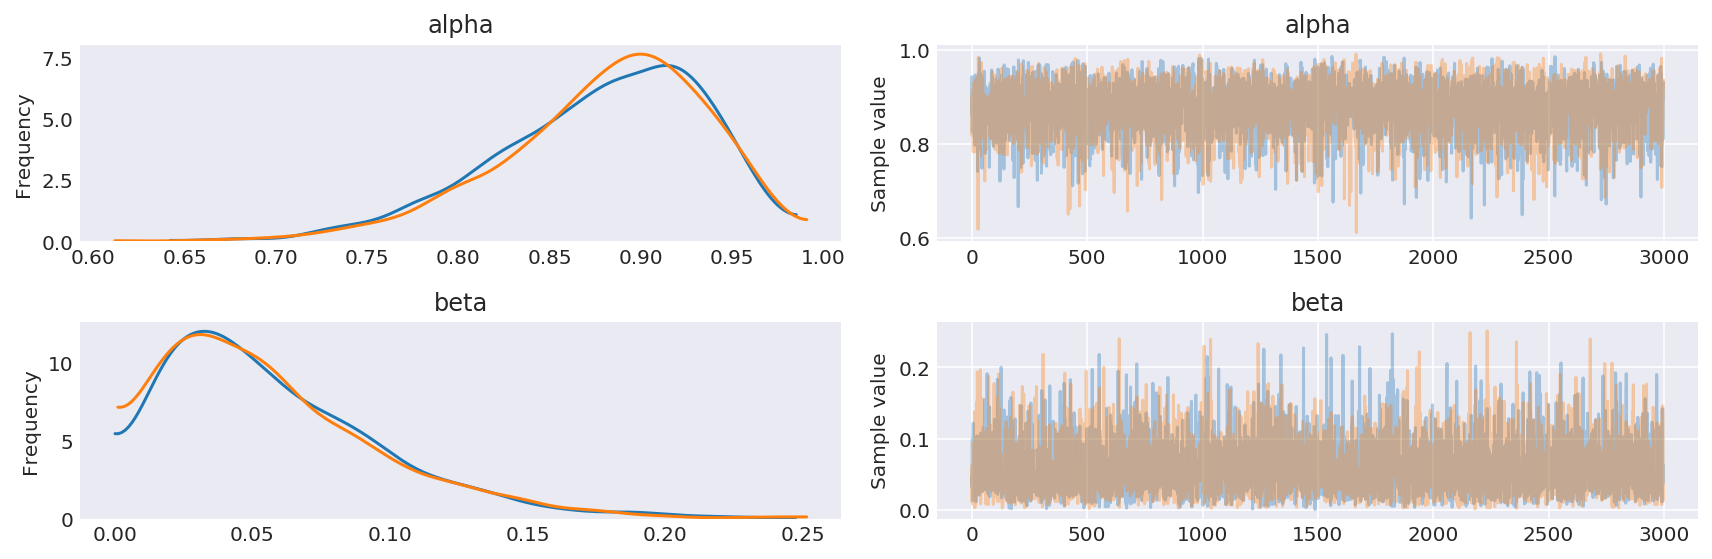

In [19]:

pm.traceplot(trace4, ['alpha', 'beta']);

xtrace = trace4['xi']
print('xi', xtrace[-1, :].flatten())
ztrace = trace4['zj']
print('zj', ztrace[-1, :].flatten())


## 6.5 Assessment of malingering

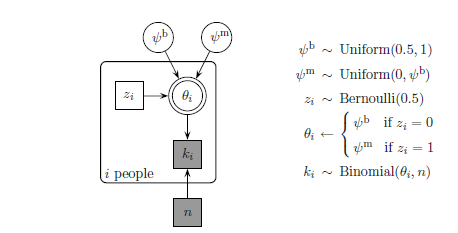

In [18]:
display(Image('./5_6_img/6_5.PNG', unconfined=True))

* 사람이 cheat을 했는지 아닌지 검사하는 어려움에 대해서 고민
* ex) 교통사고 
    * 메모리 손상으로 인해 환자인척해서 보험금 받으려는 사람이 있다.
    * 의도적으로 손상있은 것처럼 하는 것 malingering 이라고 한다.
    * $\psi^b = bona fide$ 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [psim, psib]
>BinaryGibbsMetropolis: [zi]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:09<00:00, 1529.45draws/s]


zi-last [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]


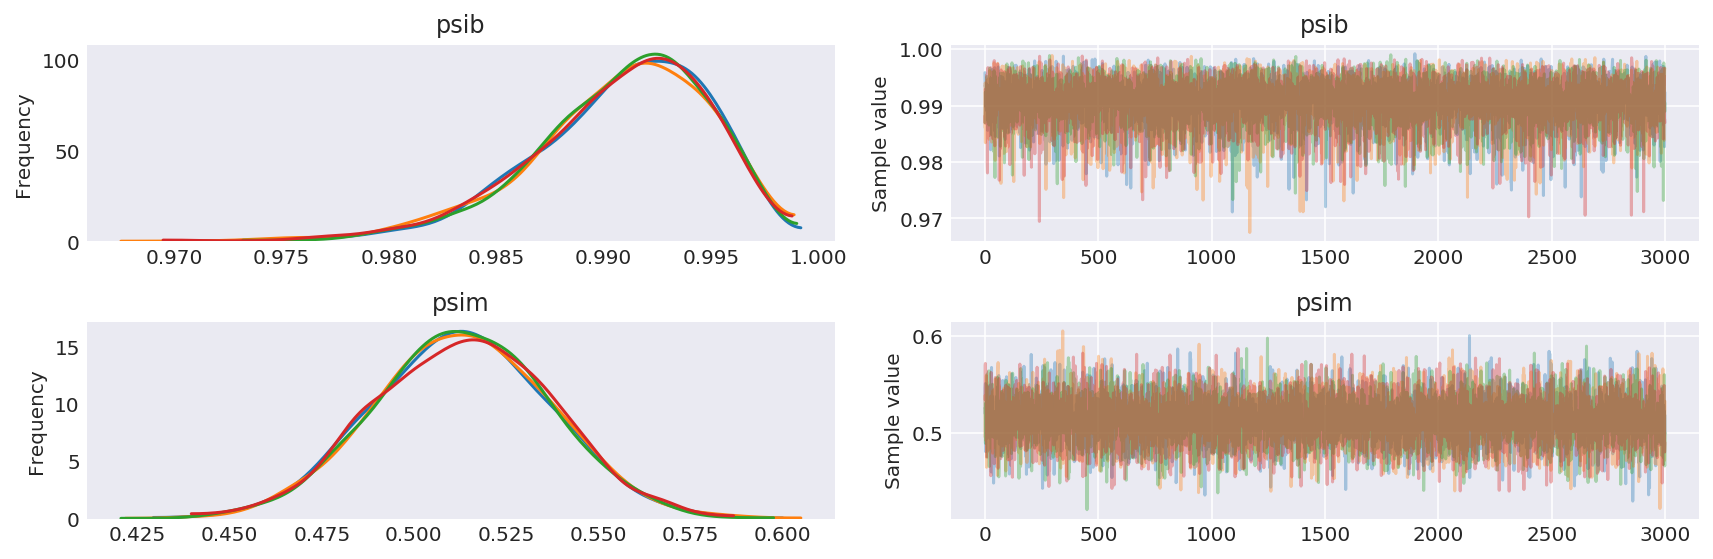

In [9]:
k = np.array([45,45,44,45,44,45,
              45,45,45,45,30,20,
              6,44,44,27,25,17,
              14,27,35,30])

p = len(k) # number of people
n = 45        # number of questions

with pm.Model() as model5:
    # prior
    ## 진실한 참여자는 확률으 0,5보다는 클 것이다.
    ## 거짓말을 하는 참여자는 더 낮게 확률이 나올 것이다.
    psib = pm.Uniform('psib', lower=0.5, upper=1)
    psim = pm.Uniform('psim', lower=0, upper=psib)
    ## 맞출 확률 
    zi = pm.Bernoulli('zi', p=.5, shape=p)
    ##  틀리면 진실된 것고 아니면 
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 0), psib, psim))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)
    
    trace5=pm.sample(3000)

pm.traceplot(trace5, ['psib', 'psim']);

ztrace = trace5['zi']
print('zi-last', ztrace[-1, :])
print('zi-mode', stats.mode(ztrace[:], axis=0).mode.squeeze())

# 6.6 Individual differences in malingering

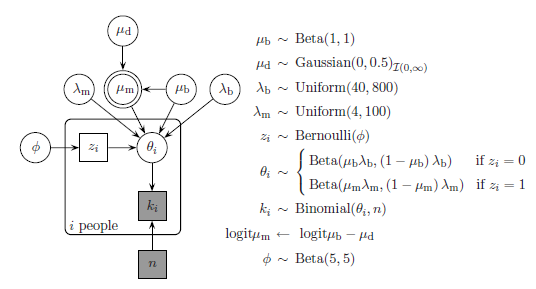

In [3]:
display(Image('./5_6_img/6_6.PNG', unconfined=True))

* 6.5에서는 한 그룹에 모든 사람이 같은 확률로 답을 한다고 가정했다.
* 가정
    * 각 그룹에 ith 참가자는 질문들에 대한을 유니크한 값을 가진다고 하자.
    * 6.2에는 gaussian으로 해서 range에 문제가 있었지만 이번에는 beta 분포를 통해서 자연스러운 비율이 있는 공간으로 가정한다.
    * $\mu = \frac{\alpha}{\alpha+\beta}$ , $\lambda = \alpha + \beta$
    * $\mu_b$ = bona fide $\mu_m$ = malingerers
    * 이전 모델과라는 다르게 logit 방식으로 이용해 paramter 간의 차이로 정의한다.

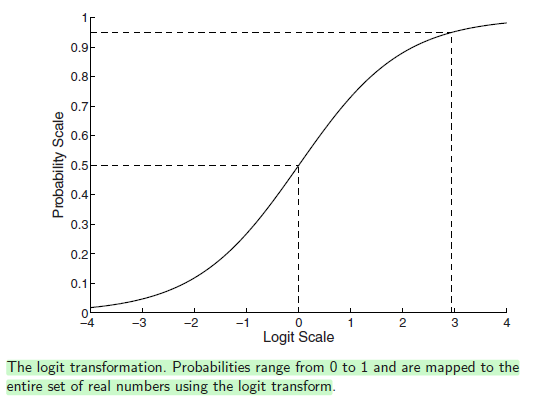

In [5]:
display(Image('./5_6_img/6_6_1.PNG', unconfined=True))

In [10]:
## 이해가 잘 안되는 구조 

k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30])
p = len(k) # number of people
n = 45        # number of questions

with pm.Model() as model6:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=40, upper=800)
    lambdam = pm.Uniform('lambdam', lower=4, upper=100)
    psi = pm.Beta('psi', alpha=5, beta=5)
    
    zi = pm.Bernoulli('zi', p=psi, shape=p)
    
    mum = pm.Deterministic('mum', 1/(1+tt.exp(tt.log(1/mub-1)+mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=mum*lambdam, beta=(1-mum)*lambdam)
    
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 0), theta1, theta2))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)
    trace6 = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta2, theta1, psi, lambdam, lambdab, mud, mub]
>BinaryGibbsMetropolis: [zi]
Sampling 4 chains: 100%|██████████| 42000/42000 [01:13<00:00, 569.43draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


zi-last [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1]
zi-mode ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), count=array([[35000, 35000, 35000, 35000, 35000, 35000, 35000, 35000, 35000,
        35000, 35000, 35000, 35000, 35000, 35000, 35000, 35000, 35000,
        35000, 35000, 34997, 35000]]))


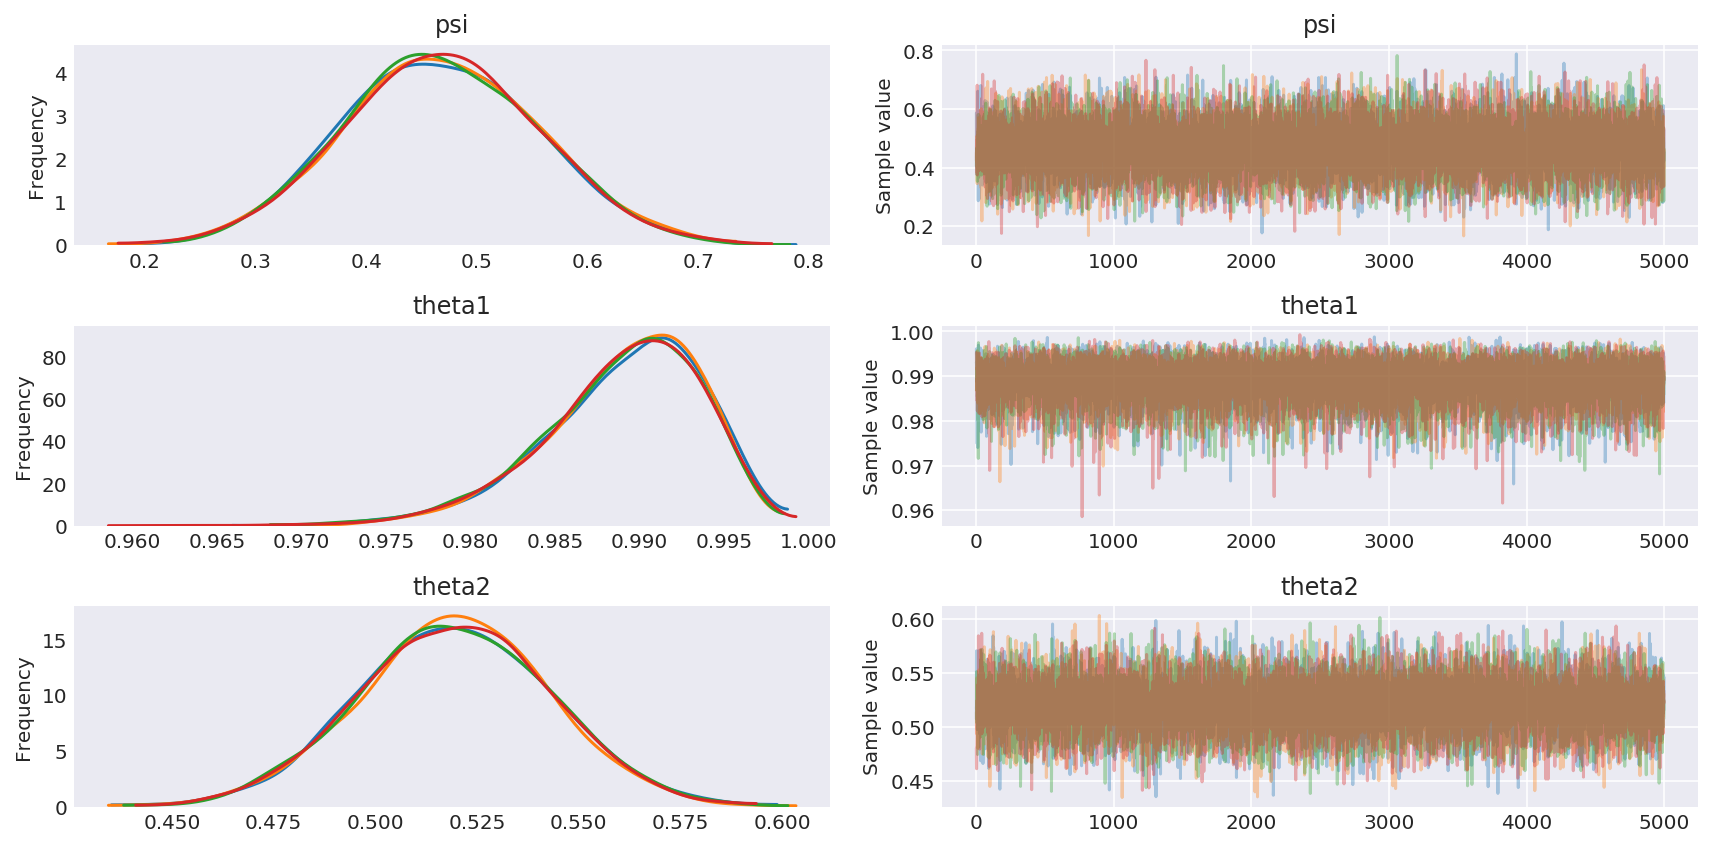

In [11]:
burnin = 5000
pm.traceplot(trace6[burnin:], ['psi', 'theta1', 'theta2']);

ztrace = trace6['zi'][burnin:]
print('zi-last', ztrace[-1, :])
print('zi-mode', stats.mode(ztrace[:], axis=0))

## 6.7 Alzheimer's recall test cheating

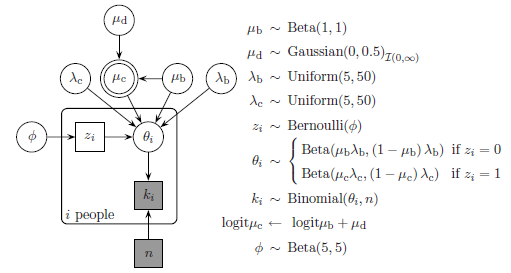

In [4]:
display(Image('./5_6_img/6_7.PNG', unconfined=True))

* 6.7에서는 6.6  latent mixture model을 다른 메모리 테스트 데이터에 적용할 것입니다..
* 간단한 인식 및 회상 작업은 알츠하이머 병 및 관련 장애 (ADRD)를 검사하는 중요한 부분이며 때로는 전화로 관리됩니다.
* 118명의 사람 데이터로 진행
    * 사용 된 특별한 테스트는 즉각적이고 지연된 자유 리콜 작업의 복잡한 순서였습니다.
    * 우리는 각자 40 명 중 한 명이 정확한 점수를 내도록 단순화했습니다.
    * 의도적으로이 일을 수행 한 것으로 알려진 61 명의 선량한 사람들과 속임수를 쓰는 것으로 알려져있는 57 명의 사람들이 의도적으로 설계되었습니다.
    
* 그것은 변수의 이름을 malingering에서 cheating으로 적절하게 변경하고, 그룹 배포판의 정밀도에 대해 다른 priors를 사용하며, 사기꾼의 정확도 비율을 선량한 사람들의 정확도보다 높게 만든다. 
* 그렇지 않은 경우보다 더 많은 단어를 상기하십시오.

In [22]:

with pm.Model() as model7:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=5, upper=50)
    lambdac = pm.Uniform('lambdac', lower=5, upper=50)
    psi = pm.Beta('psi', alpha=5, beta=5)
    # psi = pm.Uniform("psi",lower=0,upper=1)
    zi = pm.Bernoulli('zi', p=psi, shape=p)
    
    muc = pm.Deterministic('muc', 1/(1+tt.exp(tt.log(1/mub-1)-mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=muc*lambdac, beta=(1-muc)*lambdac)
    
    theta = pm.Deterministic('theta', tt.switch(tt.eq(zi, 1), theta1, theta2))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=n, observed=k)

logp = -623.74, ||grad|| = 0.076462: 100%|██████████| 51/51 [00:00<00:00, 1075.14it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [theta2, theta1, psi, lambdac, lambdab, mud, mub]
Sampling 4 chains: 100%|██████████| 14000/14000 [01:01<00:00, 226.37draws/s]
The acceptance probability does not match the target. It is 0.910661158910102, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


zi [0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1
 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 1 0 0]
zi ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0]]), count=array([[6000, 6000, 6000, 6014, 6000, 6000, 6008, 6036, 6004, 6003, 6000,
        6000, 6000, 6000, 6000, 6000, 6032, 6004, 6001, 6003, 6033, 6013,
        6003, 6016, 6000, 6089, 6000, 6000, 6002, 6000, 6015, 6000, 6003,
        6000, 6015, 6002, 6000, 6036, 6092, 6000, 6017, 6037, 6000, 6005,
        6000, 6000, 6000, 6000

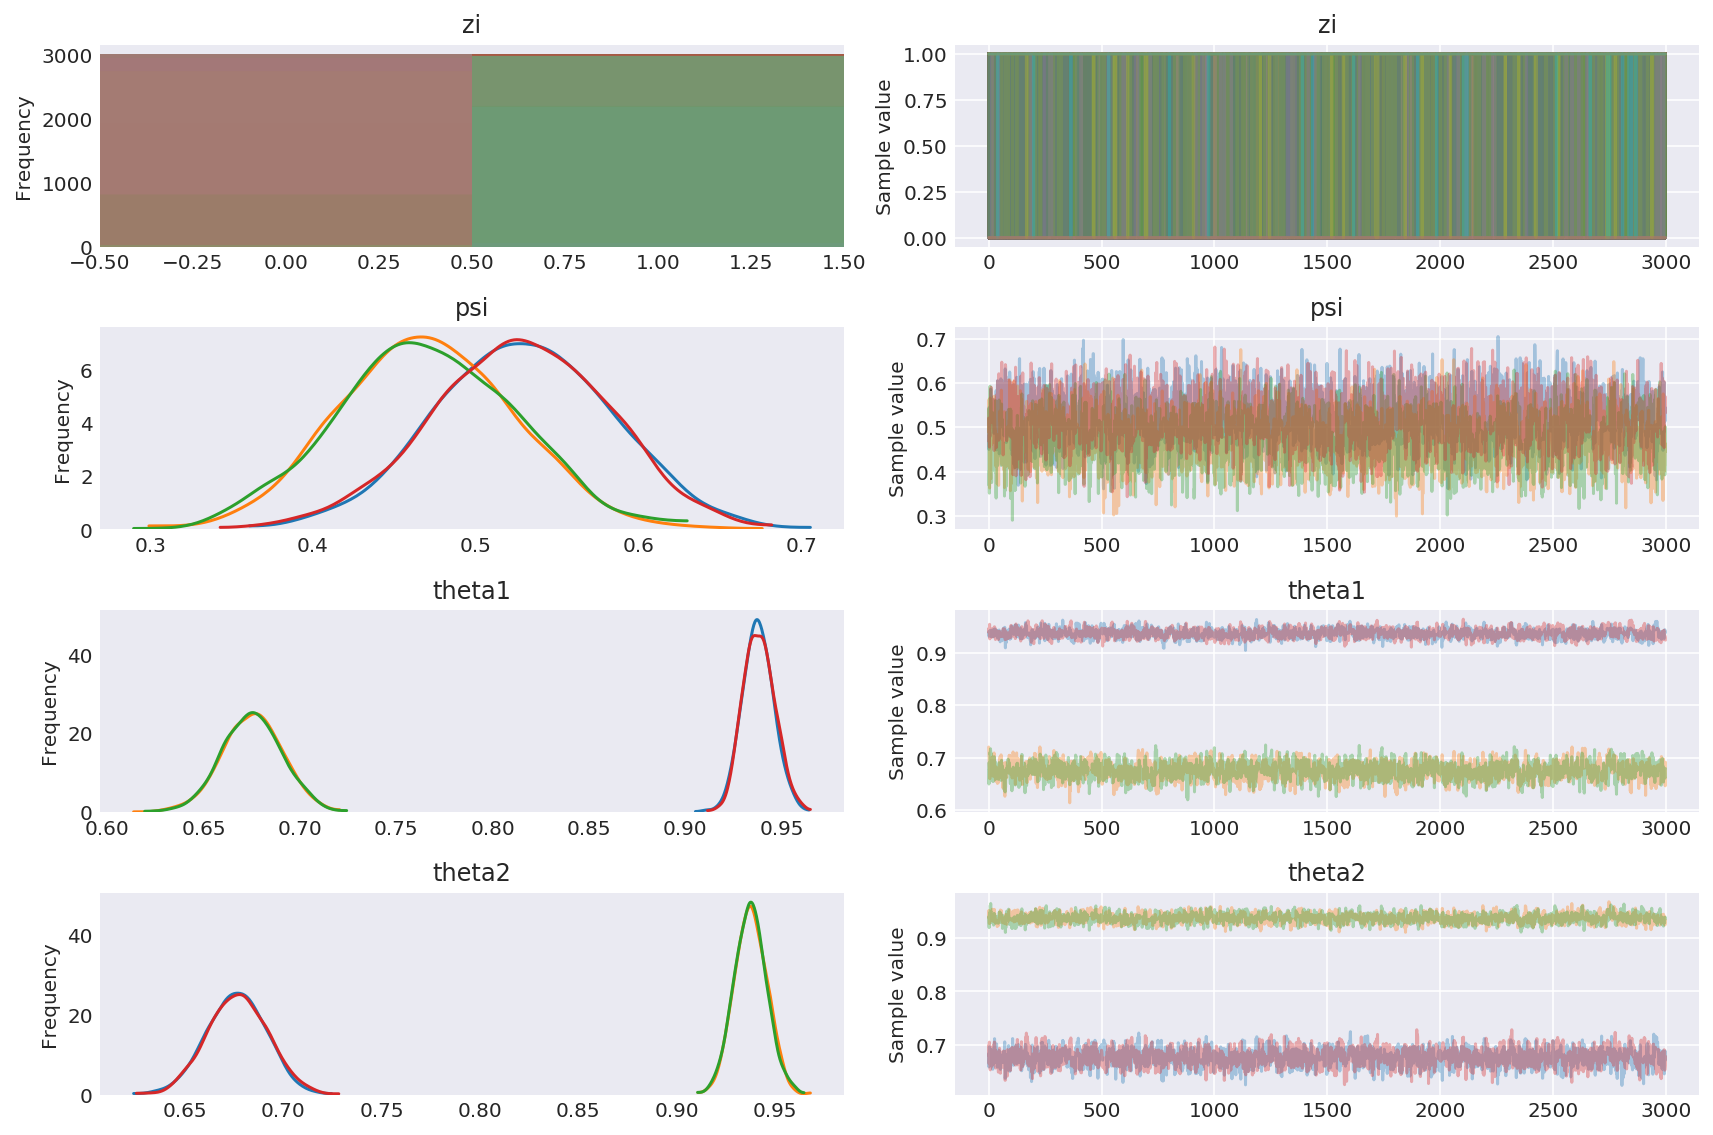

In [23]:
with model7:
    start = pm.find_MAP()
    start['zi']=np.random.binomial(1,.5,p)
    trace7=pm.sample(3000, start=start, init=None)

burnin=0
pm.traceplot(trace7[burnin:],varnames=['zi','psi','theta1','theta2']);

ztrace = trace7['zi'][burnin:]
print('zi',ztrace[-1,:])
print('zi',stats.mode(ztrace[:],axis=0))
print(np.mean(ztrace[-1:]==(t1[0,:]==1)))

0.7627118644067796


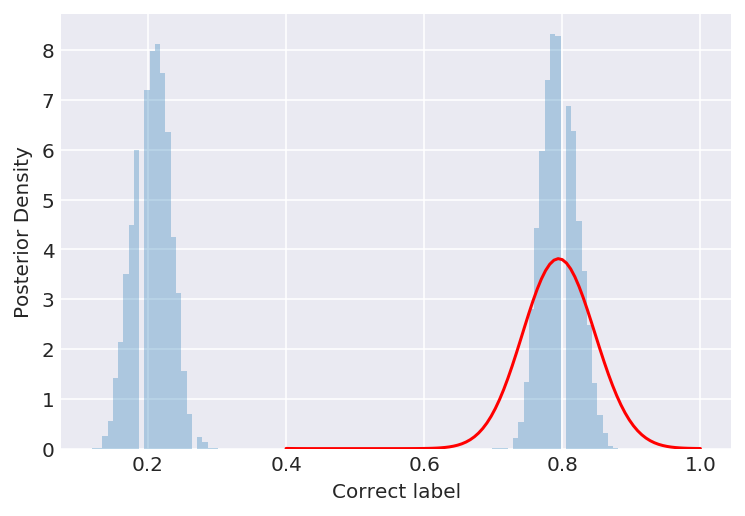

In [24]:
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

ztrace = trace7['zi']

print(np.mean(ztrace[-1:]==(t1[0,:]==1)))
pc=np.mean(ztrace==(t1[0,:]==1),axis=1)

my_pdf = gaussian_kde(pc)
x=np.linspace(.4, 1, 100)
plt.plot(x,my_pdf(x),'r') # distribution function
plt.hist(pc, bins=100, normed=1, alpha=.3)
plt.xlabel('Correct label')
plt.ylabel('Posterior Density');

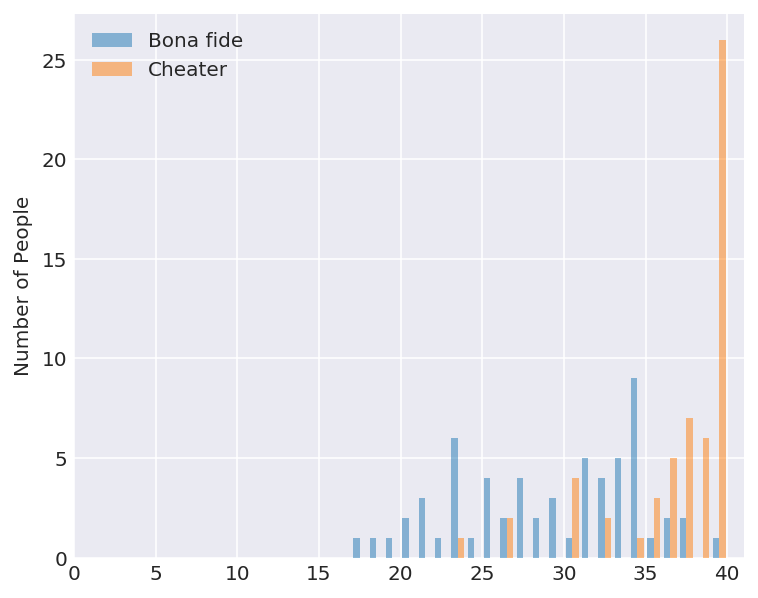

In [21]:
cheat_dir = "https://raw.githubusercontent.com/pymc-devs/resources/master/BCM/ParameterEstimation/cheat.csv"
cheatt_dir = "https://raw.githubusercontent.com/pymc-devs/resources/master/BCM/ParameterEstimation/cheatt.csv"
        
dat = pd.read_csv(cheat_dir ,header=None)
truth = pd.read_csv(cheatt_dir,header=None)
k = np.array(dat.sum(axis=1))
t1 = truth.values.T

p = len(k) # number of people
n = 40     # number of questions

fig = plt.figure(figsize=(6, 5))
bins = np.arange(0,n+1)
plt.hist([k[t1[0,:]==0],k[t1[0,:]==1]], bins, alpha=0.5, label=['Bona fide','Cheater'])
plt.xlim([0,41])
plt.legend(loc='upper left')
plt.ylabel('Number of People');        

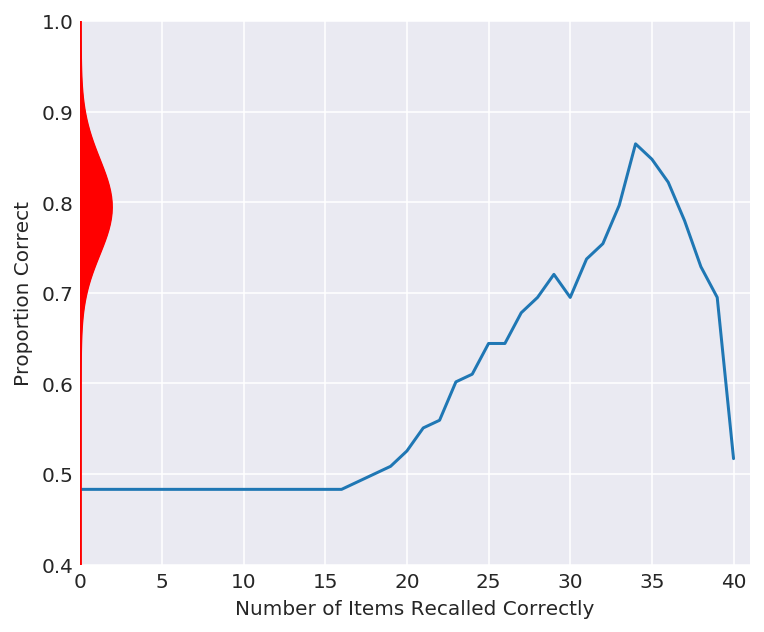

In [25]:
fig = plt.figure(figsize=(6, 5))
my_pdf = gaussian_kde(pc)
x = np.linspace(0.4, 1, 100)
tmp = np.zeros(n+1)
for i in range(n+1):
    tmp[i] = np.mean((k>i)==(t1[0,:]==1))
plt.plot(tmp)
pdfpc=my_pdf(x)/2
plt.plot(pdfpc,x,'r') 
plt.fill_between(pdfpc,x,0,color='r')
plt.axis([0,41,.4,1])
plt.xlabel('Number of Items Recalled Correctly')
plt.ylabel('Proportion Correct');

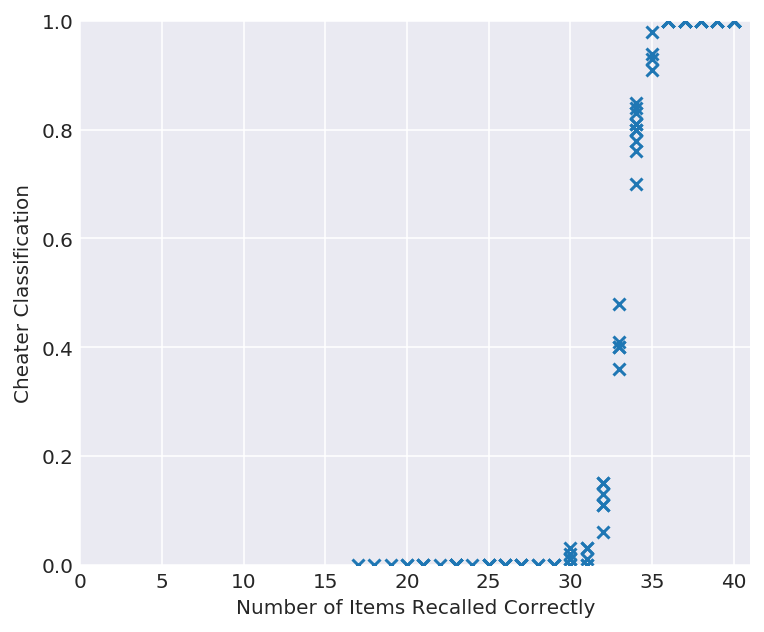

In [26]:

pc2=np.mean(ztrace[0:100],axis=0)
# pc2.shape
plt.figure(figsize=(6, 5))
plt.scatter(k, pc2,marker='x')
plt.axis([0,41,0,1]);
plt.xlabel('Number of Items Recalled Correctly')
plt.ylabel('Cheater Classification');

* The relationship between the number of items recalled correctly, and the posterior classification as belonging to the cheater group.